<center><h2>Smart Search for Rental Properties Search using Web Scrapping</h2><center>

#### 1) Executive Summary

Web scraping, the process of using computer programs to automate data extraction from
websites, can be very useful for a variety of users having different needs. Real estate
professionals, renters and also landlords can benefit from the dataset we built as the housing/rent
market is one of the most dynamic ones. In our project, we have utilized diverse web scraping
techniques such as MongoDB, json, BeautifulSoup and API. For this report, we have limited the
rent listings to San Francisco, California in the United States. We have scraped 

**a) Zip code repository website**

**b) Zillow website** 

**c) Google Maps API**

Combining all of the information collected from the fore-mentioned websites and API, we aim to provide a user looking for
properties to rent with the nearest and most relevant set of properties along with the price,
distance and various other informative features that help him/her shortlist the properties they
want to visit and check out or even make a buy/rent decision. That is, we aim to mainly benefit
zillow users or anyone who is looking for properties to buy or rent by helping them make more
informed decisions

#### 2) Background, Context, and Domain Knowledge

We will look for rental properties on Zillow, one of the leading home rental and real
estate websites in the market. Scraping rent listings on Zillow.com enables us to search
properties in any location even though in the report, we have limited the location to where we
live, San Francisco, CA. We are able to extract detailed information such as full addresses, price,
number of bedrooms and bathrooms, and all other information available on the website. In this
project, we have scraped all of San Francisco zip codes and the listings within those zip codes. A
common use case of this project would be when a user wants to see the nearest rental listings by
providing their current address or the neighborhood they want to live in. The listings can also be
filtered by the distance specified by a user from a certain address or zip code. Users will be able
to see and compare different features and characteristics of the listings such as price or number
of bedrooms and bathrooms. The database we have created will provide the users with a low to
no cost tool, not to mention the fast speed of the web scraping.


#### Web-scraping and Processing

#### Importing Libaries, Loading directories and Conneting to Database

In [1]:
import requests
import re
import json
import pandas as pd
from datetime import datetime
from requests import Session
from bs4 import BeautifulSoup as bs
import random
from random import randint
from time import sleep
import time
import os
from scrapy import Selector

### Creating header with autherization
header = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
                           'Accept-Language': 'en-US, en;q=0.5',"Authorization": "Bearer #Addbarertoken"}

### Opening MongoDB Client and Conecting to database
from pymongo import MongoClient
import json
import pandas as pd
client = MongoClient('mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&directConnection=true&ssl=false')

#### Step 1 : Captuting all San Francisco zip codes

To begin with, as we have to capture all the rental listings present in the entire San
Francisco, we need to collect zip codes. To obtain them, we used the zipcodes.com website
(https://www.zip-codes.com/county/ca-san-francisco.asp). This website provides all the zipcodes
with respect to any county in the entire United States. We are limiting the city to San Francisco
for this project; however, by changing the county part in this link, we can easily expand the
scope of our project and produce results for a different city or multiple cities as well should a
reader of this report would like to apply this web scraping model to other cities.

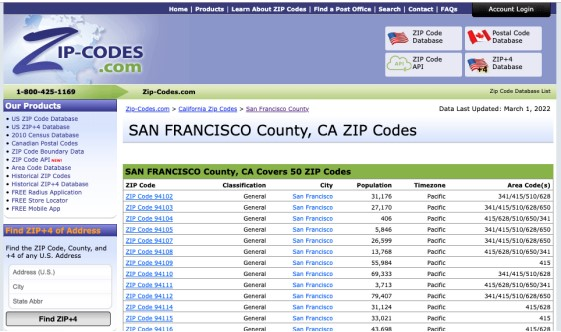

We found the table structure on the web page above and went through each table detail to
capture the zip codes of San Francisco. We used BeautifulSoup to convert the captured web page
structure into a html format to parse through them. After saving the page as a beautifulsoup
object, we utilized it to find zip codes and stored them in our dataframe 

#### Code

In [2]:
### Initializing state and Zipcode lists
state = []
zip_code = []

### Creating the url for each zip
url = "https://www.zip-codes.com/county/ca-san-francisco.asp"

### Capturing the page
page = requests.get(url,headers=header)

### Creating a soup element
soup = bs(page.text, 'lxml')

### Find the table with zip codes
listings = soup.find_all("td",{"class":"label"})

### Loading the lists with zip codes
for z in listings:
    if len(z.text)==14 and z.text[0:8]=="ZIP Code":
        state.append("CA")
        zip_code.append(z.text[9:])

In [3]:
### Creating data frame with the lists
zips = pd.DataFrame(list(zip(state, zip_code)),
               columns =['state', 'zip_code'])
zips

,state,zip_code
0,CA,94102
1,CA,94103
2,CA,94104
3,CA,94105
4,CA,94107
5,CA,94108
6,CA,94109
7,CA,94110
8,CA,94111
9,CA,94112


#### Step 2 : Capturing the rental house listings of all the zipcodes in San Francisco

We leveraged zip codes captured above for San Francisco to find the rental listings on
Zillow.com. We created a generic URL to iterate through all the zip codes in San Francisco.

<center><b>URL Structure : https://www.zillow.com/”State”-”Zipcode”/rentals/<b></center>
        
For example, for California with zip code 94103, the link would look like:
https://www.zillow.com/ca-94103/rentals/. Below is the screenshot of the search result.

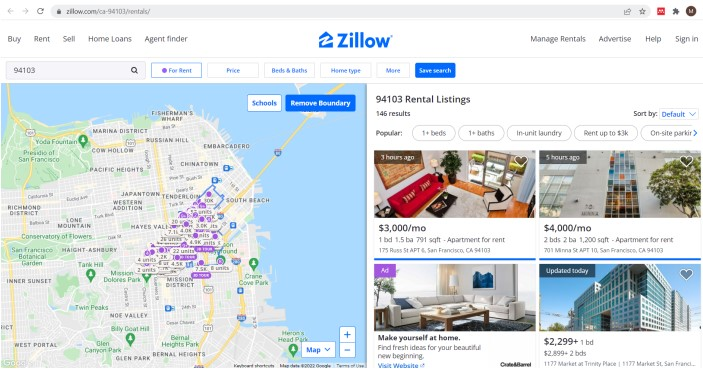

Once we reach the search result page for a specific zip code, we see the total number of listings
and the actual listings on the right side. Our objective is to capture the information from all of the
listings in the search result. We tried scrapping the information but the challenge was that we
could capture only the top 10 listings as zillow has the feature of loading only when you scroll.
Therefore, we had to find a way around to get the details in the page. After examining the page
structure, we found out that there is a json object embedded inside the page to retrieve
information while scrolling. We then captured the json object and parsed through that to get the
listing information.

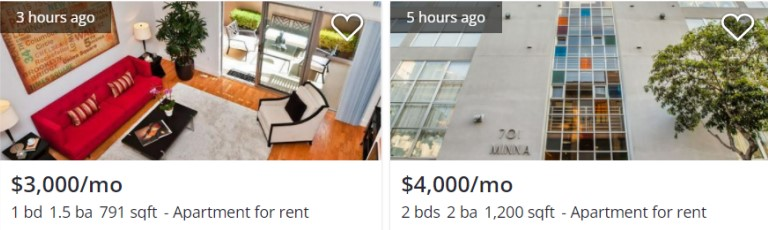

For every listing we captured :
Zpid, imgSrc, detailUrl, statusType, statusText, addressStreet, zipcode, city, state, latitude,
longitude, price, bathrooms, bedrooms, livingArea, homeType, homeStatus, daysOnZillow
isFeatured, shouldHighlight, isRentalWithBasePrice, isPremierBuilder, currency, and country.
Once we capture the details from the page, the next step is to do pagination to capture all the
listings from multiple pages. We used a pagination variable in the generic URL to iterate
through multiple pages. The URL looks like:

<center><b>Pagination URL : https://www.zillow.com/”State”-”Zipcode”/rentals/”pagenumber”_p </b></center>

We kept on increasing the page number until the captured listings are equal to the total number of
listings of the given zip code.

#### Code

In [4]:
start = 0
for x in range(0,len(zips)):
    
    ### Creating the url for each zip
    url = "https://www.zillow.com/" + zips["state"][x] + "-" + zips["zip_code"][x] + "/rentals/"
    
    ### Capturing the page
    page = requests.get(url,headers=header)
    
    ### Creating a soup element
    soup = bs(page.text, 'lxml')
    
    ### Skipping of there are no results
    br = 0
    h5s = soup.findAll("h5")
    for hs in h5s:
        if hs.text == "No matching results":
            br=1
            
    if br==1:
        continue
    
    
    ### Capturing total number of listings available in given zip code
    count = soup.findAll("span",{"class":"result-count"})
    for i in count:
        val = pd.to_numeric(i.text.split(" ")[0])

    stop  = 0
    total = 0
    interator = 1
    while stop<1:
        
        ### Random sleep
        sleep(randint(3,8))
        
        ### Creating the url for each zip with pagenation 
        url = "https://www.zillow.com/" + zips["state"][x] + "-" + zips["zip_code"][x] + "/rentals/"+ str(interator) + "_p/"

        ### Capturing the pages 
        page = requests.get(url,headers=header)

        ### Creating a soup element
        soup = bs(page.text, 'lxml')
        
        ### Capturing the script element which consists of json object
        listings = soup.find_all("script",{"data-zrr-shared-data-key":"mobileSearchPageStore"})

        ### Converting the element into json object
        for i in listings:
            js = str(i).replace('<script data-zrr-shared-data-key="mobileSearchPageStore" type="application/json"><!--',"")
            js = js.replace('--></script>',"")
        js = json.loads(js)
        
        ### Traversing through the json object to find the House deatils
        houses = pd.DataFrame(pd.json_normalize(js["cat1"]["searchResults"]["listResults"]))
        
        ### Filtering the columns needed to be saved
        data = houses[['zpid','id','imgSrc','detailUrl','statusType','statusText','addressStreet','hdpData.homeInfo.streetAddress',
                        'hdpData.homeInfo.zipcode','hdpData.homeInfo.city','hdpData.homeInfo.state',
                        'hdpData.homeInfo.latitude', 'hdpData.homeInfo.longitude','hdpData.homeInfo.price', 
                        'hdpData.homeInfo.bathrooms','hdpData.homeInfo.bedrooms', 'hdpData.homeInfo.livingArea',
                        'hdpData.homeInfo.homeType', 'hdpData.homeInfo.homeStatus','hdpData.homeInfo.daysOnZillow', 
                        'hdpData.homeInfo.isFeatured','hdpData.homeInfo.shouldHighlight','hdpData.homeInfo.isRentalWithBasePrice',
                        'hdpData.homeInfo.isPremierBuilder','hdpData.homeInfo.isZillowOwned',
                        'hdpData.homeInfo.currency', 'hdpData.homeInfo.country']]
        
        ### Innitiationg final data collection of house details
        if start==0:
            final = data
            start=1
        else:
            final = pd.concat([final,data],axis=0)
        total = total + len(data)
        interator = interator + 1
        
        ### Stopping the pagenations once we capture all the existing results
        if total >= val:
            stop=1
            
    ### Printing the zip codes completed      
    print(zips["state"][x] + " " + zips["zip_code"][x] + " : " + str(total) + " Listings")

### Renaming the columns 
pd.set_option("display.max_rows", None, "display.max_columns", None)
final.columns = final.columns.str.replace('hdpData.homeInfo.', '')

### Eleminating the houses whose details are not properly available
final = final[final['streetAddress'].notna()]

CA 94102 : 75 Listings
CA 94103 : 139 Listings
CA 94104 : 3 Listings
CA 94105 : 45 Listings
CA 94107 : 103 Listings
CA 94108 : 71 Listings
CA 94109 : 306 Listings
CA 94110 : 203 Listings
CA 94111 : 10 Listings
CA 94112 : 57 Listings
CA 94114 : 98 Listings
CA 94115 : 132 Listings
CA 94116 : 59 Listings
CA 94117 : 104 Listings
CA 94118 : 125 Listings
CA 94121 : 112 Listings
CA 94122 : 123 Listings
CA 94123 : 110 Listings
CA 94124 : 25 Listings
CA 94127 : 26 Listings
CA 94129 : 9 Listings
CA 94131 : 53 Listings
CA 94132 : 17 Listings
CA 94133 : 104 Listings
CA 94134 : 27 Listings
CA 94158 : 13 Listings


C:\Users\mahen\AppData\Local\Temp/ipykernel_23740/582920019.py:86: FutureWarning: The default value of regex will change from True to False in a future version.
  final.columns = final.columns.str.replace('hdpData.homeInfo.', '')


#### Total Linstings count

In [16]:
len(final)

1684

#### Displaying 10 captured Listings

In [7]:
final.head(10)

,zpid,id,imgSrc,detailUrl,statusType,statusText,addressStreet,streetAddress,zipcode,city,state,latitude,longitude,price,bathrooms,bedrooms,livingArea,homeType,homeStatus,daysOnZillow,isFeatured,shouldHighlight,isRentalWithBasePrice,isPremierBuilder,isZillowOwned,currency,country
2,2073360498,2073360498,https://photos.zillowstatic.com/fp/e3f39b83b61...,https://www.zillow.com/homedetails/455-Eddy-St...,FOR_RENT,Apartment for rent,455 Eddy St #T0201,455 Eddy St #T0201,94102,San Francisco,CA,37.783443,-122.415050,1725.0,1.0,0.0,471.0,APARTMENT,FOR_RENT,-1.0,True,False,False,False,False,USD,USA
10,2071568997,2071568997,https://photos.zillowstatic.com/fp/e9f13d1c458...,https://www.zillow.com/homedetails/57-Taylor-S...,FOR_RENT,Apartment for rent,57 Taylor St #122,57 Taylor St #122,94102,San Francisco,CA,37.782880,-122.410850,1795.0,1.0,0.0,212.0,APARTMENT,FOR_RENT,-1.0,True,False,False,False,False,USD,USA
12,2080768124,2080768124,https://photos.zillowstatic.com/fp/da300e1a07a...,https://www.zillow.com/homedetails/50-Laguna-S...,FOR_RENT,Apartment for rent,50 Laguna St APT 207,50 Laguna St APT 207,94102,San Francisco,CA,37.771600,-122.425020,2395.0,1.0,0.0,361.0,APARTMENT,FOR_RENT,-1.0,True,False,False,False,False,USD,USA
16,2099178438,2099178438,https://photos.zillowstatic.com/fp/e59cde4ced2...,https://www.zillow.com/homedetails/455-Hayes-S...,FOR_RENT,Apartment for rent,455 Hayes St,455 Hayes St,94102,San Francisco,CA,37.776627,-122.423874,5200.0,2.0,2.0,1000.0,APARTMENT,FOR_RENT,-1.0,False,False,False,False,False,USD,USA
18,2065624848,2065624848,https://photos.zillowstatic.com/fp/066de4da0c9...,https://www.zillow.com/homedetails/587-Ofarrel...,FOR_RENT,Apartment for rent,587 Ofarrell St #3,587 Ofarrell St #3,94102,San Francisco,CA,37.785435,-122.414314,1200.0,1.0,0.0,NaN,APARTMENT,FOR_RENT,-1.0,False,False,False,False,False,USD,USA
20,2065641305,2065641305,https://photos.zillowstatic.com/fp/69c0a6a54f8...,https://www.zillow.com/homedetails/222-Lily-St...,FOR_RENT,Apartment for rent,222 Lily St #1,222 Lily St #1,94102,San Francisco,CA,37.774384,-122.424710,3800.0,1.0,2.0,NaN,APARTMENT,FOR_RENT,-1.0,False,False,False,False,False,USD,USA
21,2070349917,2070349917,https://photos.zillowstatic.com/fp/6de7ac96918...,https://www.zillow.com/homedetails/24-Franklin...,FOR_RENT,Apartment for rent,24 Franklin St FLOOR 7-ID112,24 Franklin St FLOOR 7-ID112,94102,San Francisco,CA,37.774788,-122.420700,2970.0,1.0,0.0,460.0,APARTMENT,FOR_RENT,-1.0,True,False,False,False,False,USD,USA
22,2077535807,2077535807,https://photos.zillowstatic.com/fp/56d3db31cc1...,https://www.zillow.com/homedetails/207-Gough-S...,FOR_RENT,Apartment for rent,207 Gough St #51,207 Gough St #51,94102,San Francisco,CA,37.775170,-122.422940,2300.0,1.0,0.0,NaN,APARTMENT,FOR_RENT,-1.0,True,False,False,False,False,USD,USA
24,2084246926,2084246926,https://photos.zillowstatic.com/fp/803218cb85a...,https://www.zillow.com/homedetails/8-Octavia-S...,FOR_RENT,Apartment for rent,8 Octavia St PH 6,8 Octavia St PH 6,94102,San Francisco,CA,37.772713,-122.423380,5200.0,2.5,2.0,1001.0,APARTMENT,FOR_RENT,-1.0,False,False,False,False,False,USD,USA
26,2065671261,2065671261,https://photos.zillowstatic.com/fp/71d13929977...,https://www.zillow.com/homedetails/448-Page-St...,FOR_RENT,Apartment for rent,448 Page St,448 Page St,94102,San Francisco,CA,37.773610,-122.428190,7495.0,1.5,5.0,1850.0,APARTMENT,FOR_RENT,-1.0,False,False,False,False,False,USD,USA


#### Step 3 : Saving the listing details to database

After capturing the data, we used Mongo DB to save the data. We used NoSql document
model to store data into the database. We choose NoSql database as it can handle a large amount
of data at high speed. MongoDB stores the data which has a hash table encoded with it, thereby
enabling faster retrieval of data. The other database models are relational, hierarchical, network,
object oriented and entity relationship. Out of all these relational databases are the most popular
which need proper structure and relationships built across the tables to retrieve the information.
The relational databases are ideal for performance; however, they require a lot of maintenance as
the data keeps growing whereas the NoSql MongoDB database needs minimal maintenance.
In MongoDB, we created a database zillow and also a collection named listing. Below is
the view of the table from studio3T

In [8]:
### Creasting a database zillow
zillow = client["zillow"]

### Creating a collection named listings
listings = zillow["listing"]

### Inserting the captured data
listings.insert_many(final.to_dict('records'))

#### Checking Database Existance

In [9]:
print(client.list_database_names())

['admin', 'config', 'crunchbase', 'enron_messages', 'local', 'mongomart_cart', 'mongomart_item', 'samples_friends', 'samples_pokemon', 'video_movieDetails', 'video_movies', 'video_reviews', 'yelp', 'zillow']


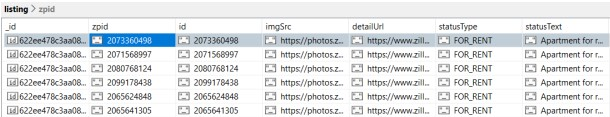

#### Step 4 : Customer search for rental house listings

Once we created the database, we made a customer facing search portal where a customer comes
to the page and gives his/her address and the range in which he/she is searching for listings from
their location. Below is the example:

In [2]:
my_address = input("Your Current Address : ")
Dis = input("Maximum distance from your place to listings in Kilometers (Fill NA distance filter is not needed) : ")

Your Current Address : clements, san francisco, CA 94118
Maximum distance from your place to listings in Kilometers (Fill NA distance filter is not needed) : 5


#### Step 5 : Feteching listings from database and finding distance from customer locations to the listins location

We received details from the customer, queried our database for all the listings and found the
distance from the customer's location to all the listings by using google maps API.

**API structure : https://maps.googleapis.com/maps/api/distancematrix/json?
destinations=”customer_address”&origins= “listing_address”&key=”apikey”**

Then, we captured the distance and time to travel from the customer's location to all the listings
from API, added that information to the database query result and filtered the result for the
distance range given by the customer. Finally, we displayed the result sorted from the nearest to
farthest from the customer's location. Below is the display for the address input and the distance
range given by the customer, sorted by distance .

#### Code

In [11]:
### Accessing the database
db = client["zillow"]

### Accessing the collection
ds = db["listing"]

### Capturing the records from the collection
house_listings = pd.DataFrame(pd.json_normalize(ds.find()))

### initializing distance and time needed
Distance = []
Time = []

### finding distance from customer loaction to the listings in database
for b in range(0,len(house_listings)):
    listing_address = house_listings["streetAddress"][b].replace("#","") + "," + house_listings["zipcode"][b] + " " + house_listings["city"][b]
    api = requests.request("GET","https://maps.googleapis.com/maps/api/distancematrix/json?destinations="+ my_address + "&origins="+ listing_address +"&key=APIKEY", headers=header)
    loc = json.loads(api.text)
    Distance.append(loc["rows"][0]["elements"][0]["distance"]["text"])
    Time.append(loc["rows"][0]["elements"][0]["duration"]["text"]) 
    
house_listings["Distance"] = Distance
house_listings["Time"] = Time

#### Displaying listings from nearest to farthest from customer's place

In [25]:
if Dis=="NA":
    display = house_listings[['streetAddress', 'zipcode', 'city', 'state','price','bathrooms', 'bedrooms','livingArea', 
                'Distance', 'Time','homeType', 'homeStatus', 'daysOnZillow','isPremierBuilder','isZillowOwned']]
else:
    house_listings["Dist"] = house_listings['Distance'].str.replace("km","").str.replace("m","").str.strip()
    house_listings = house_listings.loc[pd.to_numeric(house_listings['Dist']) <= pd.to_numeric(Dis)]
    house_listings = house_listings.sort_values(by='Dist')
    display = house_listings[['streetAddress', 'zipcode', 'city', 'state','price','bathrooms', 'bedrooms','livingArea', 
                    'Distance', 'Time','homeType', 'homeStatus', 'daysOnZillow','isPremierBuilder','isZillowOwned','Dist']]

#### Total filtered listings

In [26]:
len(display)

149

#### Displaying top 20 listings

In [27]:
display.head(20)

,streetAddress,zipcode,city,state,price,bathrooms,bedrooms,livingArea,Distance,Time,homeType,homeStatus,daysOnZillow,isPremierBuilder,isZillowOwned,Dist
1067,274 5th Ave,94118,San Francisco,CA,3995.0,1.0,2.0,1000.0,0.2 km,1 min,SINGLE_FAMILY,FOR_RENT,-1.0,False,False,0.2
1026,332 6th Ave,94118,San Francisco,CA,3895.0,1.5,2.0,1000.0,0.2 km,1 min,APARTMENT,FOR_RENT,-1.0,False,False,0.2
1070,(undisclosed Address),94118,San Francisco,CA,2500.0,1.0,2.0,NaN,0.2 km,1 min,APARTMENT,FOR_RENT,-1.0,False,False,0.2
1082,238 8th Ave,94118,San Francisco,CA,7950.0,2.5,4.0,2700.0,0.2 km,1 min,SINGLE_FAMILY,FOR_RENT,-1.0,False,False,0.2
1016,198 6th Ave,94118,San Francisco,CA,2595.0,1.0,1.0,NaN,0.3 km,1 min,APARTMENT,FOR_RENT,-1.0,False,False,0.3
1018,387 5th Ave #387,94118,San Francisco,CA,2200.0,1.0,1.0,NaN,0.3 km,2 mins,APARTMENT,FOR_RENT,-1.0,False,False,0.3
1081,272 4th Ave,94118,San Francisco,CA,4300.0,2.0,4.0,1600.0,0.3 km,2 mins,APARTMENT,FOR_RENT,-1.0,False,False,0.3
1034,272 9th Ave #272C,94118,San Francisco,CA,2300.0,1.0,1.0,692.0,0.3 km,1 min,APARTMENT,FOR_RENT,-1.0,False,False,0.3
1096,325 9th Ave APT 3,94118,San Francisco,CA,3195.0,1.0,2.0,629.0,0.3 km,1 min,APARTMENT,FOR_RENT,-1.0,False,False,0.3
1043,274A 4th Ave,94118,San Francisco,CA,2500.0,1.0,2.0,856.0,0.3 km,2 mins,APARTMENT,FOR_RENT,-1.0,False,False,0.3


For the extent of this project we focused on listings of San Francisco. However, this concept can
be scaled to any city in the United States. In addition, we have provided only a few search filters.
We can include a filter for price range, square footage, apartment type, bed rooms, and bath
rooms. This allows users to find the exact type of listing they are looking for.


#### Dataset Application and Business Value

Zillow has a huge presence in the real estate industry with over 100 million properties in
its database. Whether it is to buy or rent a house, it is an extremely important decision as it
directly affects our day-to-day lives and literally one’s “home”. For zillow users, it is important
that they are making smart and informed decisions by ensuring that they are understanding how
the real estate/rental market is changing. Our project will help individuals make better
investment decisions as cost associated with property or rental usually takes up a big chunk of
the paycheck. It will also benefit real estate agencies or brokers, this database implementation
could help them track the listings and identify trends in the market.
Not only that, we can use this dataset to predict the price or any other noticeable trends of
the properties based on zip codes. This information can essentially help users to prevent
themselves from paying over priced costs for buying or renting a place than market standards.
Also, from the opposite side of the relationship, those who are looking to sell or rent out their
property can also obtain a better idea of the market standards and accordingly determine their
listing prices or at least have an idea where their property stands compared to other listings
available on the market. In this sense, they will have a better chance of selling the property
without wasting time and energy trying to meet the desired standards of the market.
Apart from the business use cases here are a few questions that help with the efficient usage of
dataset captured:
1. What is the average rental price in any given zip code?
2. What are the types of houses available in San Francisco or any zip code?
3. How is the living area related to rental price?
4. How is the number of bedrooms and bathrooms related to the rental price?

#### Conclusion
We have scraped 3 different sources: 1) Zip code repository website 2) Zillow website 3)
Google Maps API to achieve automatic data extraction of rental listings. This dataset will benefit
individuals who are looking to rent or purchase a property and save their time and energy by
offering detailed and important information from numerous listings from Zillow. We went
beyond simply compiling information from the websites and provided a more important,
customized and most relevant set of properties along with the distance, price and other numerous
informative features. There were some challenges in the process of building the web-scraping
dataset; for instance, having to scroll down the page to be able to see all of the listings on a page.
Despite the challenges, we built a successful database by incorporating 3 different data sources
and gathering all of the information for a certain zip code or in our report, for zip codes of San
Francisco. Given the importance of choosing the right home/property for any individual, our
database will have a greater impact by helping users make an informed decision.